Setup & Imports
You'll need to log into huggingface and accept the terms of the licence for this model - see the model card for details. And when you first run this notebook you need to uncomment the following two cells to install the requirements and log in to huggingface with an access token.

In [1]:
!pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 24.2 MB/s eta 0:00:00


In [2]:
!pip install -q --upgrade transformers diffusers ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
! mkdir "/root/.huggingface"

In [5]:
! cp "drive/MyDrive/.huggingface/token" /root/.huggingface/token

In [6]:
from base64 import b64encode

import numpy
import os
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [7]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
# To the GPU we go!
vae = vae.to(torch_device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_hf_folder.py:92: UserWarning: A token has been found in `/root/.huggingface/token`. This is the old path where tokens were stored. The new location is `/root/.cache/huggingface/token` which is configurable using `HF_HOME` environment variable. Your token has been copied to this new location. You can now safely delete the old token file manually or use `huggingface-cli logout`.
  warnings.warn(


The Autoencoder (AE)
The AE can 'encode' an image into some sort of latent representation, and decode this back into an image. I've wrapped the code for this into a couple of functions here so we can see what this looks like in action:

In [8]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [9]:
data_path = '/content/drive/MyDrive/expa/layers_data/images/nfts/'

In [10]:
%ls /content/drive/MyDrive/expa/layers_data/images/


nfts/  nfts_index_ids.pkl  nfts_index.index  nfts_test_ids.pkl  temp/


In [11]:
# generate index
import numpy as np
import faiss
import pickle

In [12]:
index = faiss.IndexFlatL2(16384)

In [13]:
id_index = faiss.IndexIDMap(index)

In [14]:
test_ids, index_ids = [], []

In [49]:
count = 0
for file_name in os.listdir(data_path):
    file_path = os.path.join(data_path, file_name)
    try:
        # Open the image file with PIL
        # print(file_path)
        img = Image.open(file_path)
        # print(img.format)
        if img.format in ("JPEG","JPG"):
          # img.show()
          # encoded = torch.flatten(pil_to_latent(img.resize((512, 512))))
          # print(encoded.shape)
          if count % 10 == 0:
            test_ids.append(int(file_name))
          else:
            index_ids.append(int(file_name))
            encoded = pil_to_latent(img.resize((512, 512))).reshape(1, -1)
            # print(encoded.shape)
            # index.add(encoded.cpu())
            id_index.add_with_ids(encoded.cpu(), np.array(int(file_name)))
          print(count)
          count += 1
    except IOError:
        print(f"Error opening file: {file_path}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (156250000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326

In [51]:
faiss.write_index(id_index, '/content/drive/MyDrive/expa/layers_data/images/nfts_index.index')


In [52]:
with open('/content/drive/MyDrive/expa/layers_data/images/nfts_test_ids.pkl', 'wb') as f:
  pickle.dump(test_ids, f)

In [53]:
with open('/content/drive/MyDrive/expa/layers_data/images/nfts_index_ids.pkl', 'wb') as f:
  pickle.dump(index_ids, f)

In [15]:
id_index = faiss.read_index('/content/drive/MyDrive/expa/layers_data/images/nfts_index.index')


In [16]:
with open('/content/drive/MyDrive/expa/layers_data/images/nfts_test_ids.pkl', 'rb') as f:
  test_ids = pickle.load(f)

In [17]:
with open('/content/drive/MyDrive/expa/layers_data/images/nfts_index_ids.pkl', 'rb') as f:
  index_ids = pickle.load(f)

In [18]:
len(test_ids)

384

In [19]:
test_ids

[1354,
 1408,
 1473,
 1519,
 1562,
 1604,
 1633,
 1664,
 1701,
 1742,
 1787,
 1853,
 1900,
 1927,
 1945,
 2201,
 2004,
 2244,
 2040,
 2301,
 2054,
 22,
 60,
 89,
 161,
 183,
 212,
 251,
 305,
 326,
 385,
 449,
 504,
 551,
 598,
 634,
 664,
 690,
 741,
 775,
 842,
 2539,
 2578,
 2601,
 2629,
 2661,
 2694,
 2122,
 2777,
 2843,
 2890,
 2915,
 2934,
 2967,
 2997,
 3029,
 3053,
 3097,
 3137,
 3164,
 3199,
 3236,
 3277,
 3298,
 3345,
 3397,
 3457,
 3499,
 3553,
 886,
 925,
 941,
 984,
 1019,
 1057,
 1104,
 1153,
 1183,
 1218,
 1258,
 1301,
 1322,
 6215,
 6254,
 6289,
 3601,
 3630,
 3659,
 3707,
 3742,
 3793,
 3859,
 3897,
 3914,
 3953,
 3987,
 4027,
 4063,
 4122,
 4150,
 4186,
 4225,
 4271,
 4292,
 4362,
 4416,
 4466,
 4508,
 4563,
 4597,
 4625,
 4652,
 4704,
 4753,
 4802,
 4855,
 4889,
 4908,
 4948,
 2067,
 2418,
 2474,
 7231,
 7256,
 7311,
 7364,
 7424,
 7471,
 7521,
 7548,
 7580,
 7617,
 7666,
 4982,
 5024,
 5068,
 5115,
 5144,
 5182,
 5231,
 5267,
 5301,
 5360,
 5413,
 5467,
 5517,
 5555

In [22]:
test_ids[210]

9582

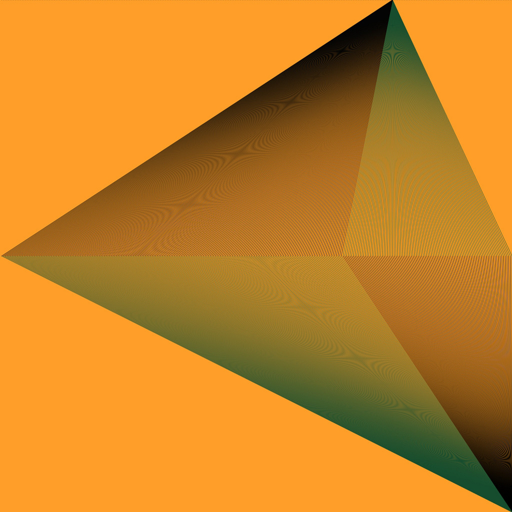

In [43]:
img = Image.open("/content/drive/MyDrive/expa/layers_data/images/nfts/" + str(test_ids[291])).resize((512, 512))
img.show()

In [44]:
encoded = pil_to_latent(img).reshape(1, -1)

In [45]:
encoded.shape


torch.Size([1, 16384])

In [46]:
# Query the index for the k most similar encodings to a given query encoding
k = 30
distances, indices = id_index.search(encoded.cpu(), k)


In [47]:
print(indices)

[[15288  1428 12318  4399  6378  3408  8358 13308  7368 10340  9349 11329
   5388   439  7859  3898 10829 12807  6868 13797 14786  5878  8849  2907
   1917  4888  9839 15777 11818 11780]]


In [48]:
print(distances)

[[4.5842513e-05 4.6105073e-05 4.6133300e-05 4.6331217e-05 4.6405490e-05
  4.6407746e-05 4.6470275e-05 4.6493424e-05 4.7251699e-05 4.7266098e-05
  4.7273687e-05 4.7726469e-05 4.7947415e-05 4.9002549e-05 1.3290119e+04
  1.3290121e+04 1.3290122e+04 1.3290122e+04 1.3290123e+04 1.3290123e+04
  1.3290123e+04 1.3290124e+04 1.3290125e+04 1.3290126e+04 1.3290127e+04
  1.3290127e+04 1.3290127e+04 1.3290128e+04 1.3290129e+04 1.3695145e+04]]


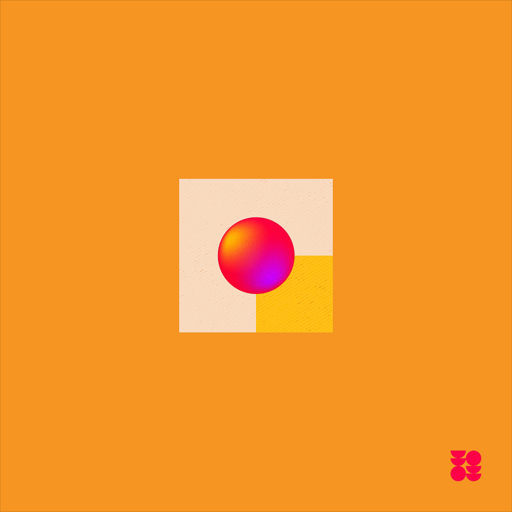

In [49]:
img = Image.open("/content/drive/MyDrive/expa/layers_data/images/nfts/" + str(indices[0][19])).resize((512, 512))
img

In [40]:
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62145  100 62145    0     0  83304      0 --:--:-- --:--:-- --:--:-- 83192


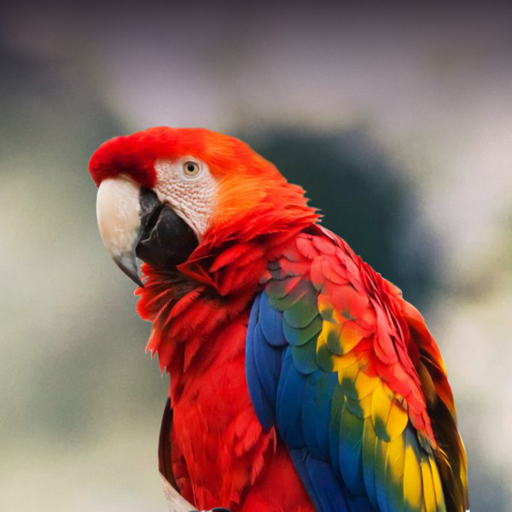

In [44]:
input_image = Image.open('macaw.jpg').resize((512, 512))
input_image

In [45]:
# Encode to the latent space
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

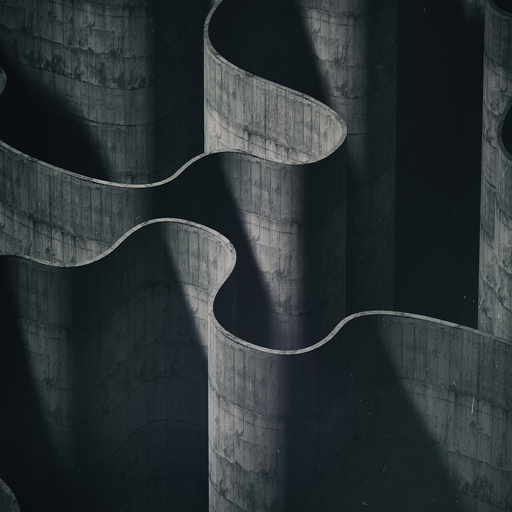

In [44]:
img = Image.open("/content/drive/MyDrive/expa/layers_data/images/nfts/1407").resize((512, 512))
img